### Machine Learning Engineer Capstone Project 

## Project: Dog Identification App 

In this notebook, I will develop an algorithm to estimate the dog's breed. This algorithm will be composed by a dog detector and a human detector. If a dog is detected in the input image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most similar.

### Roadmap

* [First](#step1):  Import Datasets 
* [Second](#step2): Transform the data
* [Third](#step3):  Implement dog detector
* [Fourth](#step4): Implement human detector
* [Fifth](#step5):  Implement dog breed estimator

<a id='step1'></a>

## 1<sup>st</sup>: Import datasets

The datasets that I will use are obtain from:
* [Standford database for dog breeds images](https://www.kaggle.com/c/7327/download-all) dataset from kaggle competition
* the human images from "[Labeled Faced in the Wild](http://vis-www.cs.umass.edu/lfw/)".

For dog-breed dataset, I will download the zip for the kaggle competition that gives us the data divided in train and test. The zip file will be upload to the jupiter notebook repository and then I must unzip the file.

In [1]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2020-01-15 21:42:54--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  5.61MB/s    in 1m 45s  

2020-01-15 21:44:39 (7.21 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-01-15 21:44:39--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  10.7MB/s    in 1.9s    

2020-01-15 21:44:41 (10.7 MB/s) - ‘annotat

In [19]:
#!mkdir dogs_data
#!mkdir dogs_data/generated
#!mkdir dogs_data/train
#!mkdir dogs_data/train_annotation
#!mkdir dogs_data/validation
#!mkdir dogs_data/validation_annotation
!tar -xf images.tar -C dogs_data/
!tar -xf annotation.tar -C dogs_data/

Now I import all the libraries necessary in the notebook

For the Human datasets, I will use the sklearn datasets facilities.

In [ ]:
from sklearn.datasets import fetch_lfw_people

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=2)

## 2<sup>nd</sup>: Transform the data

In this section, we will transform the dog dataset because we need the right tensors for input for the pre-trained models that I will use in the detectors

In [20]:
import numpy as np

from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import torch

import os
from xml.dom import minidom
import json
import shutil
from random import shuffle

First I make a dicti

In [21]:
dogs_categories = {}
category_counter = 0
for name in os.listdir("./dogs_data/Annotation"): 
    if os.path.isdir("./dogs_data/Annotation/"+name):
        dogs_categories[name[10:]] = category_counter
        category_counter += 1

In [22]:
for directory in os.listdir("./dogs_data/Annotation"): 
    annotation_directory = "./dogs_data/Annotation/"+directory
    if os.path.isdir(annotation_directory):
        for file in os.listdir(annotation_directory):
            if os.path.isfile(annotation_directory+"/"+file):
                # parse an xml file by name
                mydoc = minidom.parse(annotation_directory+"/"+file)
                fileName =file
                jsonFile = fileName +'.json'
                line = {}
                # move image to upper directory
                shutil.move('./dogs_data/Images/'+directory+'/'+fileName+'.jpg', './dogs_data/Images/')
                # build the json required
                line['file'] = fileName+".jpg"
                line['image_size'] = [{
                    'width':int(mydoc.getElementsByTagName('width')[0].firstChild.data),
                    'height':int(mydoc.getElementsByTagName('height')[0].firstChild.data),
                    'depth':mydoc.getElementsByTagName('depth')[0].firstChild.data
                }]
                line['annotations'] = []
                for box in mydoc.getElementsByTagName('bndbox'):
                    line['annotations'].append({
                        'class_id':int(dogs_categories[mydoc.getElementsByTagName('name')[0].firstChild.data]),
                        'top':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[1].firstChild.data),
                        'left':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[3].firstChild.data),
                        'width':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[5].firstChild.data),
                        'height':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[7].firstChild.data)})
                line['categories']=[]
                line['categories'].append({
                    'class_id':int(dogs_categories[mydoc.getElementsByTagName('name')[0].firstChild.data]),
                    'name':mydoc.getElementsByTagName('name')[0].firstChild.data
                })
                if line['annotations']:
                    with open(os.path.join('./dogs_data/generated', jsonFile),'w') as p:
                        json.dump(line,p)

In [23]:
# delete directories
for directory in os.listdir("./dogs_data/Images"): 
    images_directory = "./dogs_data/Images/"+directory
    if os.path.isdir(images_directory):
        shutil.rmtree(images_directory)

In [24]:
path, dirs, files = next(os.walk('./dogs_data/Images'))

print ('There are {} images in directory'.format(len(files)))

jsons = os.listdir('./dogs_data/generated')

print ('There are {} images have annotation files'.format(len(jsons)))

shuffle(jsons)

There are 20580 images in directory
There are 20581 images have annotation files


In [31]:
path, dirs, files = next(os.walk('./dogs_data/train'))
for i in files:
    shutil.move('./dogs_data/generated/'+i.split('.')[0]+'.json', './dogs_data/train_annotation/')

In [45]:
path, dirs, files = next(os.walk('./dogs_data/validation'))
for i in files:
    shutil.move('./dogs_data/generated/'+i.split('.')[0]+'.json', './dogs_data/validation_annotation/')

In [42]:
train_jsons = jsons[:16464]
val_jsons = jsons[16464:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './dogs_data/Images/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './dogs_data/train/')
    shutil.move('./dogs_data/generated/'+i, './dogs_data/train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './dogs_data/Images/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './dogs_data/validation/')
    shutil.move('./dogs_data/generated/'+i, './dogs_data/validation_annotation/')

### Upload to S3

In [33]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::491576157094:role/service-role/AmazonSageMaker-ExecutionRole-20191208T094449
CPU times: user 240 ms, sys: 4.55 ms, total: 244 ms
Wall time: 524 ms


In [34]:
bucket = sess.default_bucket()
prefix = 'Dogs-Breed'

In [35]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:latest


In [36]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='./dogs_data/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='./dogs_data/validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='./dogs_data/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='./dogs_data/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 2min 15s, sys: 8.37 s, total: 2min 24s
Wall time: 12min 32s


In [37]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training

In [38]:
dog_detector_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [48]:
dog_detector_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=80,
                             mini_batch_size=16,
                             epochs=5,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=16464)

In [40]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

In [49]:
dog_detector_model.fit(inputs=data_channels, logs=True)

2020-01-19 13:46:56 Starting - Starting the training job...
2020-01-19 13:46:57 Starting - Launching requested ML instances...
2020-01-19 13:47:53 Starting - Preparing the instances for training.........
2020-01-19 13:49:13 Downloading - Downloading input data..............................
2020-01-19 13:54:19 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[01/19/2020 13:54:23 INFO 140295625463616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'

In [50]:
dog_detector = dog_detector_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

--------------------------------------------------------------------------!

In [87]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/2/25/Affenpinscher_dog.jpg
file_name = './dogs_data/Images/n02085620_10074.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

--2020-01-19 17:14:29--  https://upload.wikimedia.org/wikipedia/commons/2/25/Affenpinscher_dog.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19258 (19K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  18.81K  --.-KB/s    in 0.01s   

2020-01-19 17:14:29 (1.68 MB/s) - ‘test.jpg’ saved [19258/19258]



In [88]:
dog_detector.content_type = 'image/jpeg'
results = dog_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[3.0, 0.050276704132556915, 0.006265908479690552, 0.4896217882633209, 0.44029900431632996, 0.88245689868927], [79.0, 0.04290726035833359, 0.18787270784378052, 0.040871113538742065, 0.9291569590568542, 0.8474386930465698], [79.0, 0.03504161909222603, 0.0, 0.2599553167819977, 0.7897615432739258, 1.0], [3.0, 0.03261958062648773, 0.0, 0.3433404564857483, 0.3230893313884735, 0.7726879715919495], [66.0, 0.031247606500983238, 0.0, 0.0866105854511261, 0.5463544726371765, 0.7627708911895752], [79.0, 0.030184758827090263, 0.20384296774864197, 0.5249731540679932, 0.9582822322845459, 1.0], [32.0, 0.02967916429042816, 0.0, 0.475845068693161, 0.631992757320404, 0.808265209197998], [36.0, 0.029265832155942917, 0.23665452003479004, 0.3747622072696686, 0.9276546239852905, 0.9134557247161865], [66.0, 0.028746629133820534, 0.019808828830718994, 0.5312087535858154, 0.7663524746894836, 1.0], [28.0, 0.028626687824726105, 0.0, 0.3000210225582123, 0.5555422306060791, 0.9684088230133057], [32.0

In [102]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : dict
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:            
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            key_list = list(classes.keys()) 
            val_list = list(classes.values()) 

            if classes and len(classes) > cls_id:
                class_name = key_list[val_list.index(112)]
            print(class_name)
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound
bloodhound


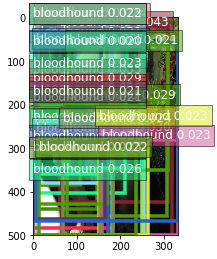

In [103]:
threshold = 0.02
  
# Visualize the detections.
visualize_detection(file_name, detections['prediction'], dogs_categories, threshold)

In [56]:
sagemaker.Session().delete_endpoint(dog_detector.endpoint)

NameError: name 'object_detector' is not defined

## 3<sup>rd</sup>: Implement Dog Detector

For dog detector I will use an Sagemaker [image detector algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).